# SKIN CANCER SEGMENTATION

![results](../assets/results.png)

This notebook aims to apply a [UNet network](https://arxiv.org/pdf/1505.04597) specialized in biomedical image segmentation in order to segment skin cancers. To do this, we used the dataset [Skin cancer: HAM10000](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/data), a easy download version of [The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions](https://doi.org/10.7910/DVN/DBW86T) and trained the network. The dataset consists of .jpg images and .png binary masks.


Developed by: **Gustavo Torres Belini - 200008 & Natanael Vitorino - 200032**



# Project requirements

In [1]:
!pip install -r ../requirements.txt

In [2]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification", force_download=True)

print("Path to dataset files:", path)

/home/nata-brain/miniconda3/envs/yolo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.59G/2.59G [01:35<00:00, 29.2MB/s]

Extracting files...


Path to dataset files: /home/nata-brain/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


In [3]:
import os
import random
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm


# Encoding
**Encoding Path:** This part of the network captures the context of the input image by using a series of convolutional and max-pooling layers to downsample the spatial dimensions. It “contracs” the original images.

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

# Decoding

**Decoding Path:** The decoding path uses upsampling and convolutional layers to produce a segmentation map that has the same spatial dimensions as the input image. It “expands” the contracted images.


In [5]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

## U-Net Architecture

The u-net architecture achieves very good performance on very different biomedical segmentation applications. U-net architecture (example for 32x32 pixels in the lowest resolution) as presented in Figure 1. Each blue box corresponds to a multi-channel feature map. The number of channels is denoted on top of the box. The x-y-size is provided at the lower left edge of the box. White boxes represent copied feature maps. The arrows denote the different operations. This work is based on [Ronneberger et al](https://arxiv.org/pdf/1505.04597).


Figure 1

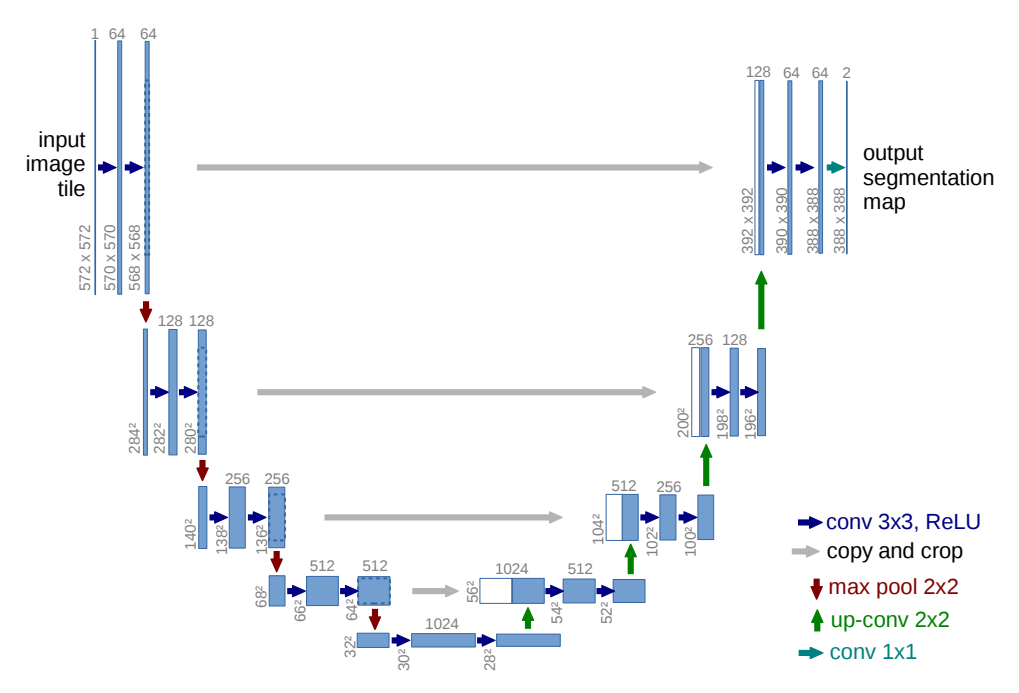


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # downsample part
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        # upsampling part
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

### Testing

The results should be: torch.Size([1, 10, 512, 512])


In [7]:
input_image = torch.rand((1,3,512,512))
model = UNet(3,10)
output = model(input_image)
print(output.size())

torch.Size([1, 10, 512, 512])


## Load the Dataset and paths

In [8]:
class SkinCancerDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "/images/" + i for i in os.listdir(root_path + "/images/")])[:self.limit] # images path
        self.masks = sorted([root_path + "/masks/" + i for i in os.listdir(root_path + "/masks/")])[:self.limit] # mask path
        assert len(self.images) == len(self.masks), "Number of images and masks must match"


        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        if index >= len(self.images):
            raise IndexError(f"Index {index} is out of bounds for dataset of size {len(self.images)}")
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask), self.images[index]

    def __len__(self):
        return min(len(self.images), self.limit)

In [9]:
DATASET_DIR =  "./"
WORKING_DIR = path
print(WORKING_DIR)

/home/nata-brain/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


In [11]:
train_dataset = SkinCancerDataset(WORKING_DIR)
generator = torch.Generator().manual_seed(25)

### Split to train, test and validation

80% for training, 10% for testing, and 10% for validation.

20% of the data for testing, 50% of this 20% for testing and the remaining 50% for validation.

In [12]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

### Selecting the device

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    num_workers = torch.cuda.device_count() * 4
    
print(device)

cuda


### LEARNING_RATE, BATCH_SIZE, dataloaders, AdamW optimizer and the BCEWithLogitsLoss loss criterion definition

In [14]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=num_workers, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

### Evaluating Segmentation Performance with the DICE Metric
DICE score = 2 * |A ∩ B| / (|A| + |B|)

Dice score = 2 * (number of common elements) / (number of elements in set A + number of elements in set B

[Dice Coefficient! What is it?](https://medium.com/@lathashreeh/dice-coefficient-what-is-it-ff090ec97bda)

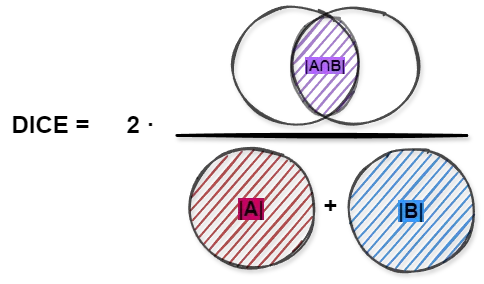

In [15]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)
    
    return dice

In [16]:
torch.cuda.empty_cache() # For clear cache

## Training the model

In [17]:
# EarlyStopper class for stop the train
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

EPOCHS = 10

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0
    
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        
        dc = dice_coefficient(y_pred, mask)
        loss = criterion(y_pred, mask)
        
        train_running_loss += loss.item()
        train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    
    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0
    
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            dc = dice_coefficient(y_pred, mask) # Dice Validation 
            
            val_running_loss += loss.item()
            val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    
    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)
    
    if early_stopper.early_stop(val_dc):             
        break

# Saving the model
torch.save(model.state_dict(), '../models/skin_cancer_v2.pth')

 10%|█         | 1/10 [07:31<1:07:46, 451.84s/it]

------------------------------
Training Loss EPOCH 1: 0.3279
Training DICE EPOCH 1: 0.7002


Validation Loss EPOCH 1: 0.2931
Validation DICE EPOCH 1: 0.7575
------------------------------


 20%|██        | 2/10 [14:57<59:44, 448.01s/it]  

------------------------------
Training Loss EPOCH 2: 0.2264
Training DICE EPOCH 2: 0.8250


Validation Loss EPOCH 2: 0.2224
Validation DICE EPOCH 2: 0.8399
------------------------------


 30%|███       | 3/10 [22:02<51:03, 437.59s/it]

------------------------------
Training Loss EPOCH 3: 0.1791
Training DICE EPOCH 3: 0.8665


Validation Loss EPOCH 3: 0.1752
Validation DICE EPOCH 3: 0.8676
------------------------------


 40%|████      | 4/10 [29:06<43:14, 432.35s/it]

------------------------------
Training Loss EPOCH 4: 0.1644
Training DICE EPOCH 4: 0.8779


Validation Loss EPOCH 4: 0.1754
Validation DICE EPOCH 4: 0.8759
------------------------------


 50%|█████     | 5/10 [36:19<36:02, 432.50s/it]

------------------------------
Training Loss EPOCH 5: 0.1550
Training DICE EPOCH 5: 0.8853


Validation Loss EPOCH 5: 0.1533
Validation DICE EPOCH 5: 0.8865
------------------------------


 60%|██████    | 6/10 [43:43<29:06, 436.57s/it]

------------------------------
Training Loss EPOCH 6: 0.1513
Training DICE EPOCH 6: 0.8871


Validation Loss EPOCH 6: 0.2040
Validation DICE EPOCH 6: 0.8458
------------------------------


 70%|███████   | 7/10 [51:04<21:53, 437.90s/it]

------------------------------
Training Loss EPOCH 7: 0.1484
Training DICE EPOCH 7: 0.8898


Validation Loss EPOCH 7: 0.1553
Validation DICE EPOCH 7: 0.8900
------------------------------


 80%|████████  | 8/10 [58:29<14:40, 440.12s/it]

------------------------------
Training Loss EPOCH 8: 0.1443
Training DICE EPOCH 8: 0.8931


Validation Loss EPOCH 8: 0.1747
Validation DICE EPOCH 8: 0.8741
------------------------------


 90%|█████████ | 9/10 [1:05:54<07:21, 441.52s/it]

------------------------------
Training Loss EPOCH 9: 0.1398
Training DICE EPOCH 9: 0.8957


Validation Loss EPOCH 9: 0.1420
Validation DICE EPOCH 9: 0.8935
------------------------------


100%|██████████| 10/10 [1:13:09<00:00, 438.99s/it]


------------------------------
Training Loss EPOCH 10: 0.1377
Training DICE EPOCH 10: 0.8971


Validation Loss EPOCH 10: 0.1423
Validation DICE EPOCH 10: 0.8933
------------------------------


### Training and validation results

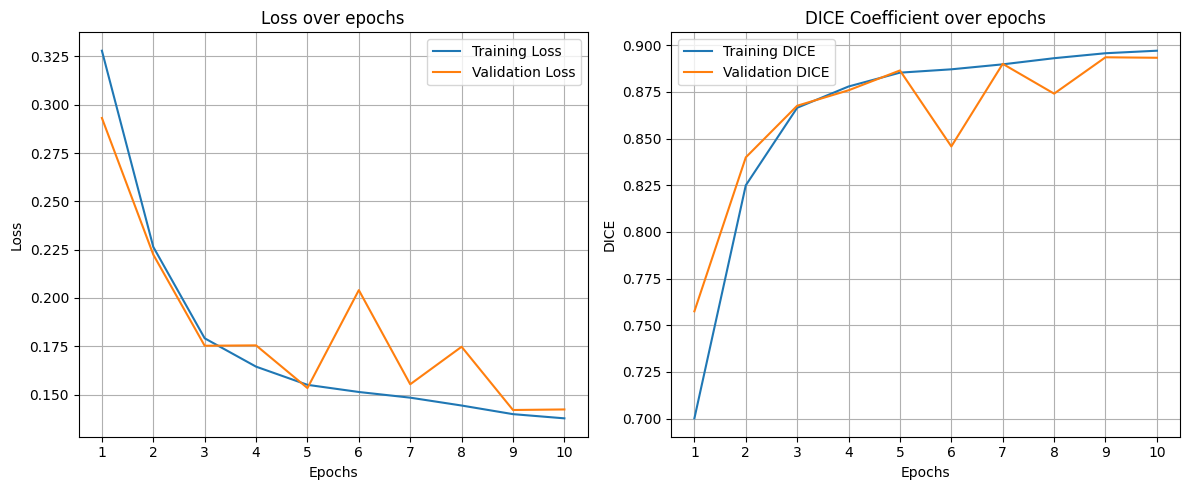

In [18]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))  
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

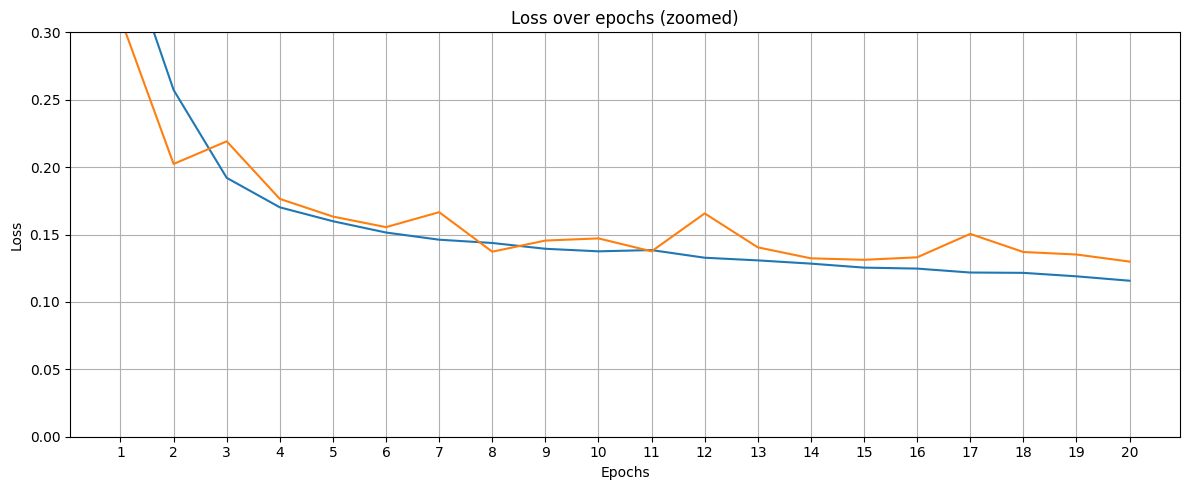

In [32]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.ylim(0, 0.3)
plt.title('Loss over epochs (zoomed)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

## Testing the model

In [19]:
model_pth = '../models/skin_cancer_v2.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

/tmp/ipykernel_26019/1115891994.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


<All keys matched successfully>

In [20]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, mask)
        dc = dice_coefficient(y_pred, mask)
        
        test_running_loss += loss.item()
        test_running_dc += dc.item()

    test_loss = test_running_loss / (idx + 1)
    test_dc = test_running_dc / (idx + 1)
    print(f"Test loss: {test_loss}, Test dc: {test_dc}")


100%|██████████| 126/126 [00:18<00:00,  6.82it/s]

Test loss: 0.14458022380454671, Test dc: 0.8940358493063185


In [55]:
# For overlay predicted image with original image
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image.
    beta = 0.7  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.
    
    color_seg_mask = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)
    color_seg_mask[:, :, 0] = 0
    color_seg_mask[:, :, 2] = 0
        
    segmented_image = cv2.cvtColor(color_seg_mask, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    return np.clip(image, 0.0, 1.0)


# Selecting random images for inference
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Resize((512, 512))
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)
        
        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)
        
        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)
        
        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice_coefficient(pred_mask, mask)),5)}")
        
        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1
        
        img_overlay = img.numpy()
        pred_mask_overlay = pred_mask.numpy()

        overlayed_image = image_overlay(img_overlay, pred_mask_overlay)

        print(f"Model: {model_pth}")
        plt.figure(figsize=(15, 16))
        plt.subplot(141), plt.imshow(img), plt.title("original")
        plt.subplot(142), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.subplot(143), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.subplot(144), plt.imshow(overlayed_image), plt.title("overlayed")
        plt.show()

## Model Inference

/tmp/ipykernel_207657/3655491088.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


Image: ISIC_0033463.jpg, DICE coefficient: 0.95799
Model: ../models/skin_cancer_v1.pth


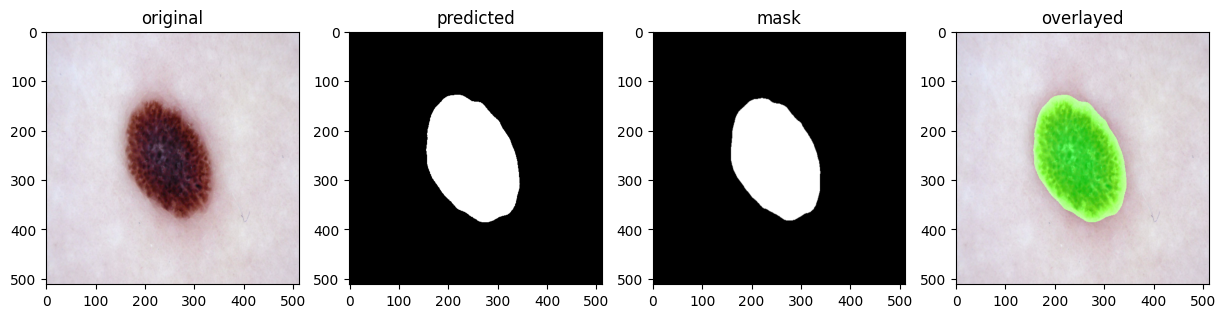

Image: ISIC_0026023.jpg, DICE coefficient: 0.79981
Model: ../models/skin_cancer_v1.pth


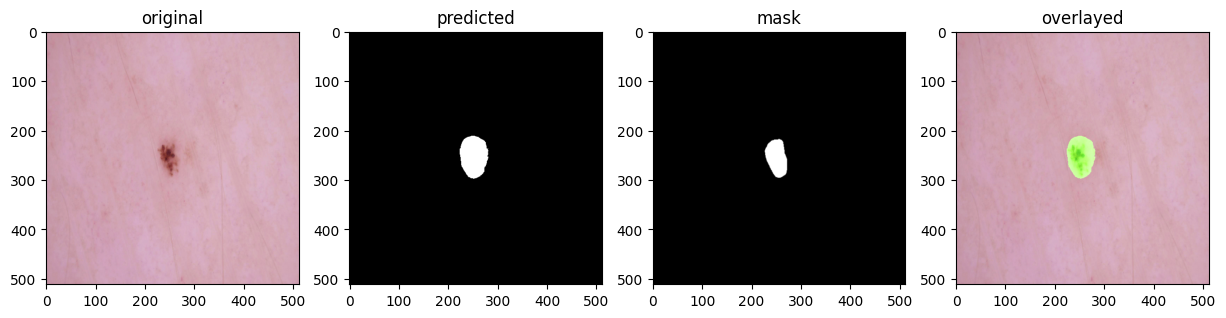

Image: ISIC_0029811.jpg, DICE coefficient: 0.79044
Model: ../models/skin_cancer_v1.pth


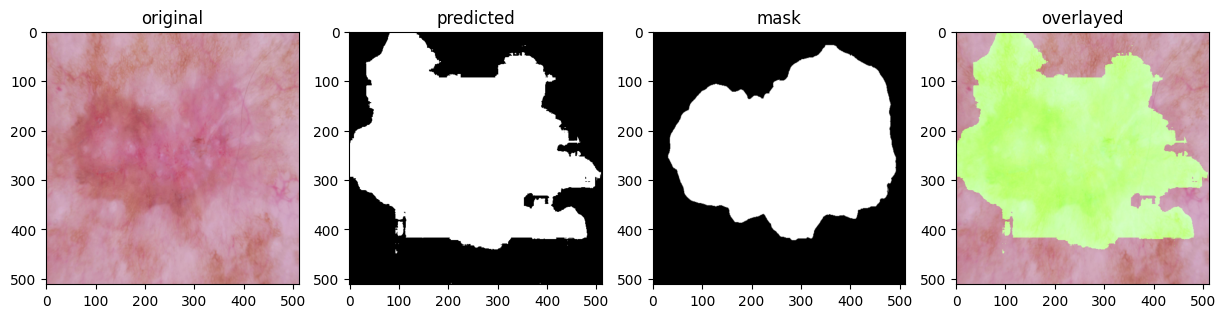

Image: ISIC_0029382.jpg, DICE coefficient: 0.90416
Model: ../models/skin_cancer_v1.pth


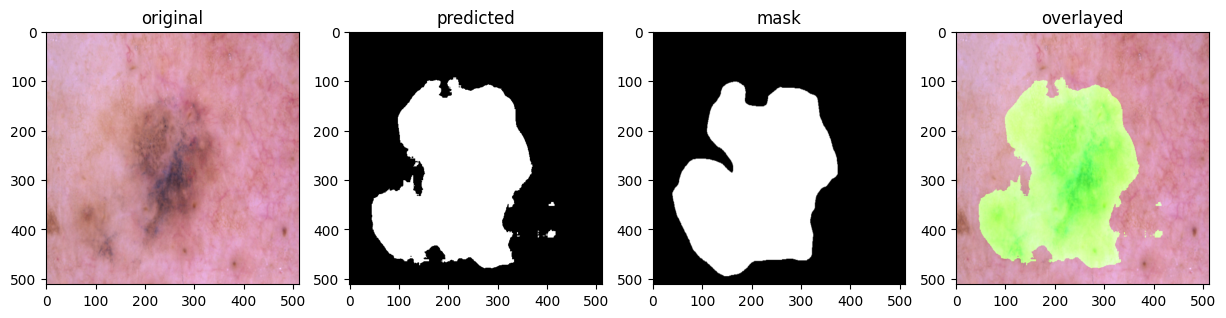

Image: ISIC_0032059.jpg, DICE coefficient: 0.80779
Model: ../models/skin_cancer_v1.pth


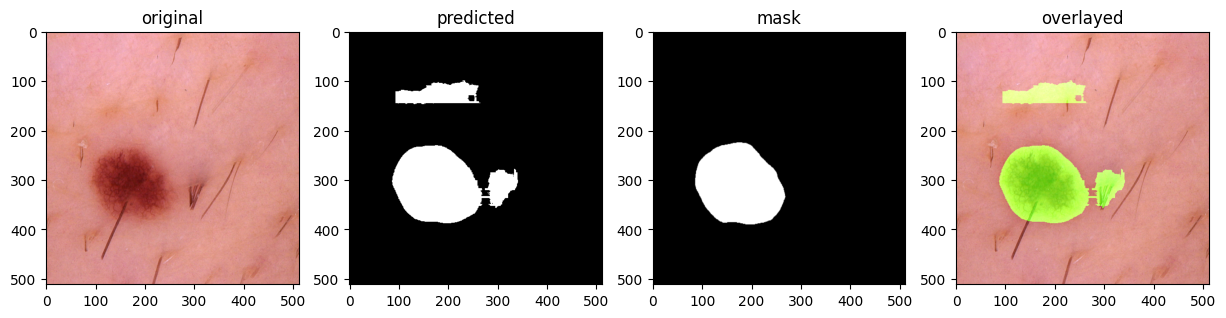

Image: ISIC_0033463.jpg, DICE coefficient: 0.96696
Model: ../models/skin_cancer_v2.pth


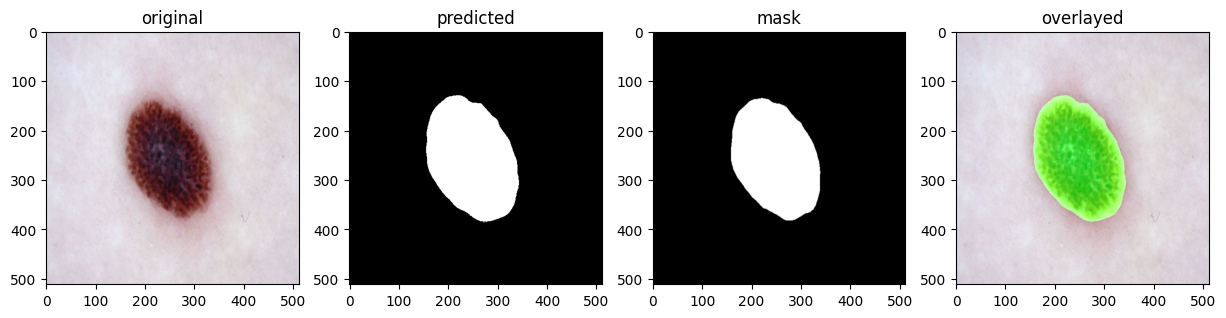

Image: ISIC_0026023.jpg, DICE coefficient: 0.89177
Model: ../models/skin_cancer_v2.pth


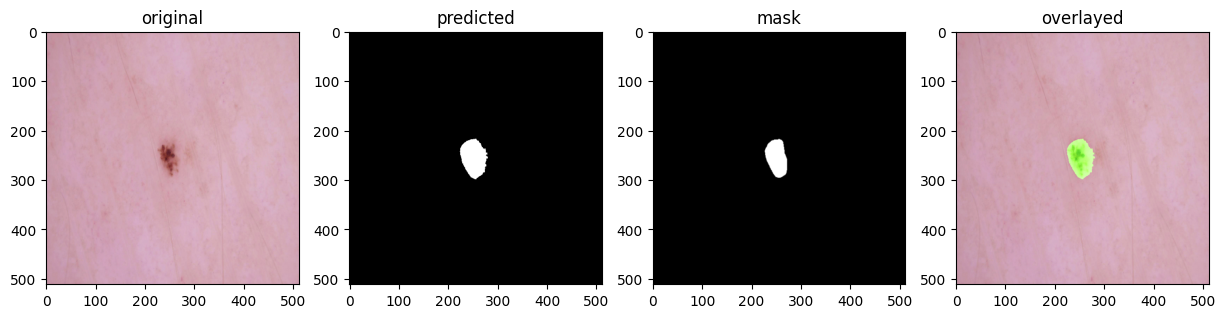

Image: ISIC_0029811.jpg, DICE coefficient: 0.74671
Model: ../models/skin_cancer_v2.pth


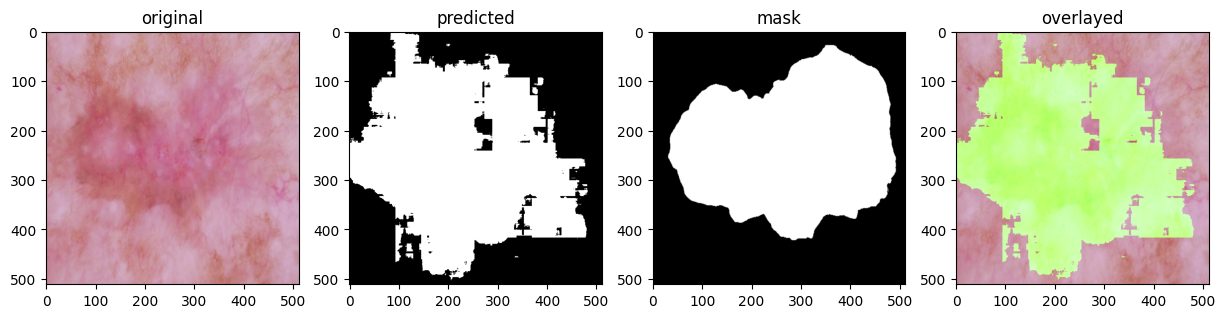

Image: ISIC_0029382.jpg, DICE coefficient: 0.85114
Model: ../models/skin_cancer_v2.pth


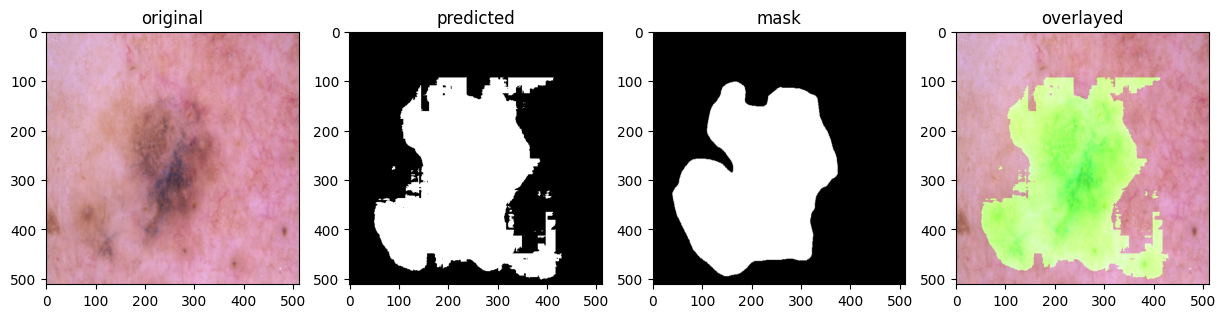

Image: ISIC_0032059.jpg, DICE coefficient: 0.87455
Model: ../models/skin_cancer_v2.pth


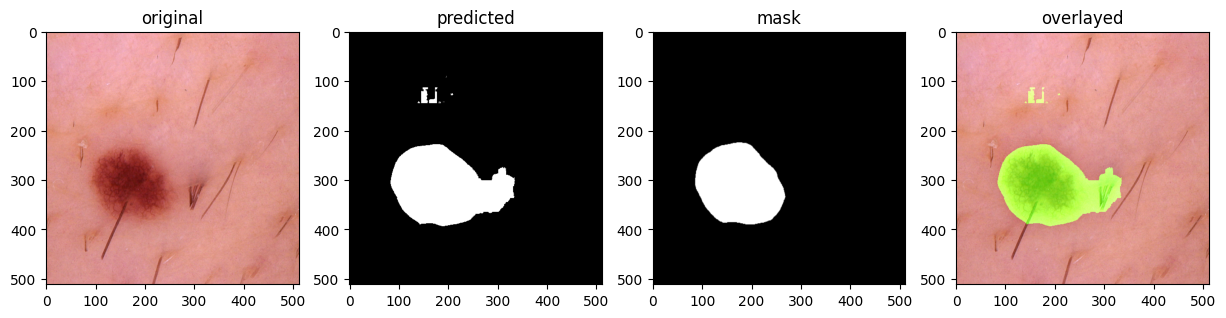

In [65]:
n = 5 # Number of images to show

image_tensors = []
mask_tensors = []
image_paths = []
model_path_v1 = '../models/skin_cancer_v1.pth'
model_path_v2 = '../models/skin_cancer_v2.pth'

for _ in range(n):
    random_index = _
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])  
    mask_tensors.append(random_sample[1]) 
    image_paths.append(random_sample[2])
    
random_images_inference(image_tensors, mask_tensors, image_paths, model_path_v1, device="cpu")
random_images_inference(image_tensors, mask_tensors, image_paths, model_path_v2, device="cpu")


# Model Training Analysis

The second version of the model has improved compared to the first, as can be seen in the image below. The two models are submitted to the same image for inference, and the following table shows the results of the inference.

The metric used to evaluate the model was the DICE score.

DICE score = 2 * |A ∩ B| / (|A| + |B|)

Dice score = 2 * (number of common elements) / (number of elements in set A + number of elements in set B


### Inference Results

| Model | Image | DICE Coeficient |
| ------------- | ------------- | ------------- |
| skin_cancer_v1.pth | ISIC_0033463.jpg | 0.95799 |
| skin_cancer_v1.pth | ISIC_0026023.jpg | 0.79981 |
| **skin_cancer_v1.pth** | ISIC_0029811.jpg | **0.79044** |
| **skin_cancer_v1.pth** | ISIC_0029382.jpg | **0.90416** |
| skin_cancer_v1.pth | ISIC_0032059.jpg | 0.80779 |

| Model | Image | DICE Coeficient |
------------- | ------------- | ------------- |
| **skin_cancer_v2.pth** | ISIC_0033463.jpg | **0.96696** |
| **skin_cancer_v2.pth** | ISIC_0026023.jpg | **0.89177** |
| skin_cancer_v2.pth | ISIC_0029811.jpg | 0.74671 |
| skin_cancer_v2.pth | ISIC_0029382.jpg | 0.85114 |
| **skin_cancer_v2.pth** | ISIC_0032059.jpg | **0.87269** |


### Test Loss and Test DICE
| Model | Test Loss | Test DICE |
| ------------- | ------------- | ------------- |
| skin_cancer_v1.pth | 0.13627266608888194 | 0.9029648516859327 |
| skin_cancer_v2.pth | 0.13620347219208875 | 0.9024439165516506 |

### Training Validation Results
By analyzing the loss and DICE graphs, we can see that from epoch 12 to 20, the model didn't learn much, but there was a small improvement in the coefficients.

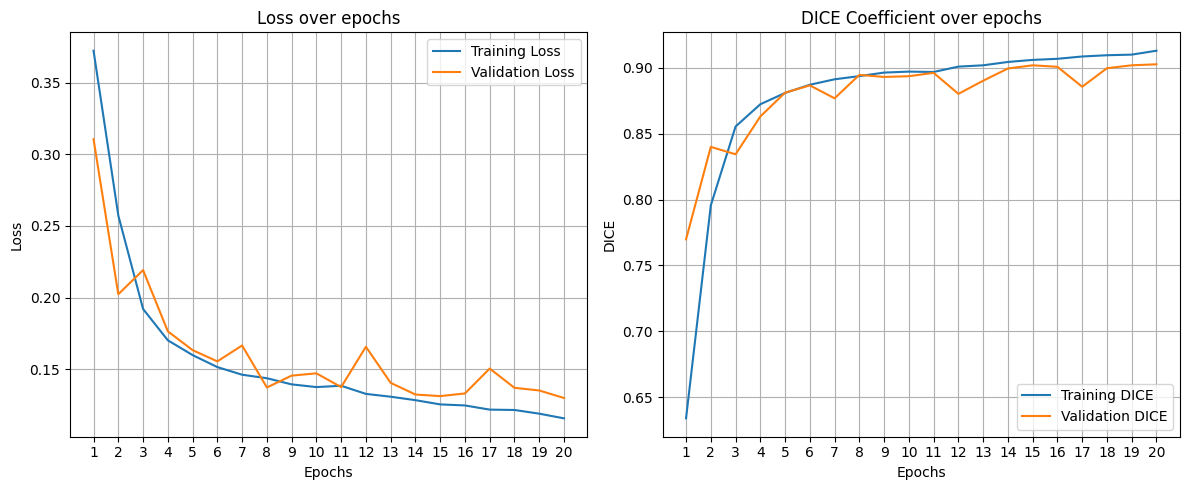

### Conclusion
It can be concluded that both models meet the objective, but version two obtained better results than the first version. This result was due to the number of training epochs, for version two there were 20 and for the first only 10.

### Next Steps
The next steps are: 
- Finding the best parameters for training the model
- Increase the number of training epochs